# PIP-PRoS: Delimitação do campo

Neste notebook o algoritmo de delimitação do campo por meio de ArUcos usado na implementação da versão robótica do jogo Pong é detalhado passo a passo.

Para mais informações, acesse [o site do projeto](https://sites.google.com/tecnico.ulisboa.pt/pip-pros/)!

## Bibliotecas utilizadas

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Imagem do campo utilizada como exemplo

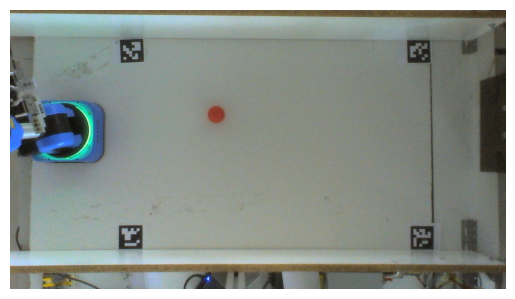

In [2]:
img = cv2.imread('../assets/images/field_example.png', 3)
h, w, _ = img.shape
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Detecção dos ArUcos

A primeira etapa para a delimitação do campo é a detecção dos ArUcos presentes na imagem. Os marcadores estão posicionados nas extremidades do campo e servem de referência dos cantos do campo para o programa.

Mais informações sobre o uso de ArUcos para a detecção de elementos da imagem podes ser encontradas na [documentação oficial do OpenCV](https://docs.opencv.org/3.4/d9/d6a/group__aruco.html).

Primeiro são configurados os parâmetros a serem utilizados pelo detector!

Na aplicação são usados ArUcos 6x6, no entanto isso pode ser alterado ao trocar o parâmetro da função ```cv2.arucos.getPredefinedDictionary()```

In [3]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250) 
parameters =  cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

O detector retorna, para cada marcador detectado, as coordenadas de cada um dos 4 cantos do ArUco no array ```corners```, assim como seus números de identificação em ```ids```.

In [4]:
corners, ids, _ = detector.detectMarkers(img)

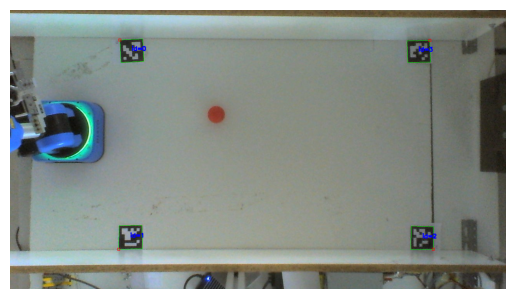

In [5]:
output_img = cv2.aruco.drawDetectedMarkers(img.copy(), corners, ids)
plt.axis("off")
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

Os ArUcos estão dispostos de forma que o primeiro canto identificado (em vermelho na imagem), coincida com a extremidade do campo que pretende ser mapeada. Caso tenha posicionado o ArUco de forma que o canto em vermelho não esteja na posição certa, basta rotacionar o ArUco!

Cada ArUco possui um ID único, de forma a simplificar esta versão do código. Dessa forma, caso todos os 4 ArUcos tenham sido detectados, é possível identificar facilmente no código qual ArUco corresponde a cada canto, como visto abaixo.

In [6]:
if len(corners) == 4:
    try:
        # The top left corner is identified by the Aruco with ID = 0
        top_left_corner_id = np.where(ids == 0)[0][0]
        
        # The bottom right corner is identified by the Aruco with ID = 2
        bottom_right_corner_id = np.where(ids == 2)[0][0]

        # The bottom right corner is identified by the Aruco with ID = 3
        top_right_corner_id = np.where(ids == 3)[0][0]

        # The bottom right corner is identified by the Aruco with ID = 1
        bottom_left_corner_id = np.where(ids == 1)[0][0]
    
        top_left_corner = corners[top_left_corner_id][0][0]
        bottom_right_corner = corners[bottom_right_corner_id][0][0]
        top_right_corner = corners[top_right_corner_id][0][0]
        bottom_left_corner = corners[bottom_left_corner_id][0][0]
        
    except:
        print("Arucos with wrong IDs!")
else:
    print("Incorrect number of ArUcos!")

Na imagem que segue é possível ver em amarelo as extremidades calculadas a partir dos ArUcos

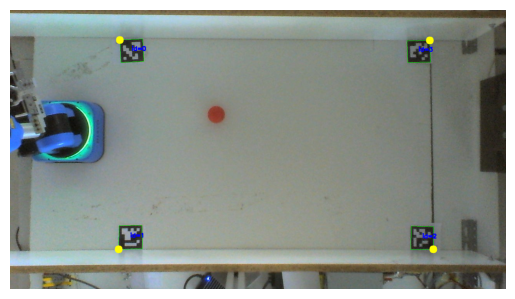

In [7]:
cv2.circle(output_img, top_left_corner.astype(int), radius=10, color=(0, 255, 255), thickness=-1)
cv2.circle(output_img, bottom_right_corner.astype(int), radius=10, color=(0, 255, 255), thickness=-1)
cv2.circle(output_img, top_right_corner.astype(int), radius=10, color=(0, 255, 255), thickness=-1)
cv2.circle(output_img, bottom_left_corner.astype(int), radius=10, color=(0, 255, 255), thickness=-1)
plt.axis("off")
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

## Ajustes de perspectiva

De forma a isolar e ajustar o campo identificado para o formato retangular esperado, foram usadas os métodos de transformação de perspectiva do OpenCV, cuja documentação pode ser acessada [por aqui](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html).

Para calcular a matriz de transformação, basta identificar os 4 pontos de entrada e saída esperados para a transformação, como pode ser visto abaixo.

In [8]:
width_top = np.hypot(
    top_left_corner[0] - top_right_corner[0], 
    top_left_corner[1] - top_right_corner[1])
width_bottom = np.hypot(
    bottom_left_corner[0] - bottom_right_corner[0], 
    bottom_left_corner[1] - bottom_right_corner[1])
max_width = max(int(width_top), int(width_bottom))

height_left = np.hypot(
    top_left_corner[0] - bottom_left_corner[0], 
    top_left_corner[1] - bottom_left_corner[1])
height_right = np.hypot(
    top_right_corner[0] - bottom_right_corner[0], 
    top_right_corner[1] - bottom_right_corner[1])
max_height = max(int(height_left), int(height_right))

input_pts = np.float32([top_left_corner, 
                        bottom_left_corner, 
                        bottom_right_corner, 
                        top_right_corner])
output_pts = np.float32([[0, 0],
                        [0, max_height - 1],
                        [max_width - 1, max_height - 1],
                        [max_width - 1, 0]])

Com esses pontos é possível calcular a matriz M de transformação de perspectiva e a sua inversa IM:

In [9]:
M = cv2.getPerspectiveTransform(input_pts, output_pts)
_, IM = cv2.invert(M)

print(M)

[[ 1.01336136e+00  5.62978531e-03 -2.87214757e+02]
 [-1.26829007e-03  1.01463205e+00 -7.77677421e+01]
 [-2.35304280e-06  2.78450557e-05  1.00000000e+00]]


Com elas, é possível obter a imagem transformada e antitransformada por meio da função ```cv2.warpPerspective```:

In [10]:
img_transformed = cv2.warpPerspective(img, M, (max_width, max_height), flags=cv2.INTER_LINEAR)
img_antitransformed = cv2.warpPerspective(img_transformed, IM, (w, h), flags=cv2.INTER_LINEAR)

Text(0.5, 1.0, 'Imagem antitransformada')

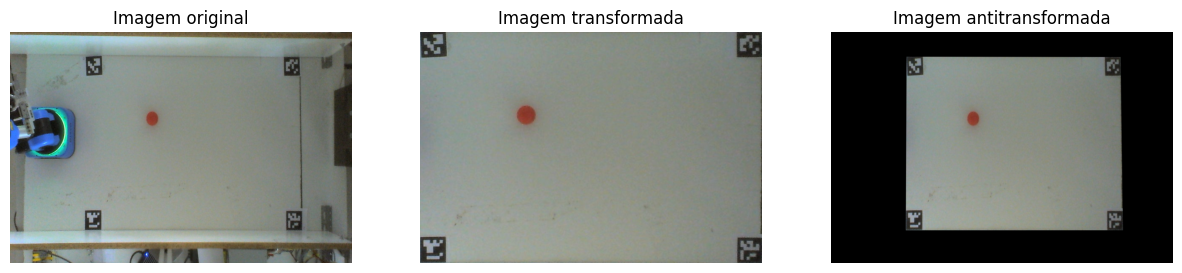

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for ax in axes:
    ax.axis("off")

axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect="auto")
axes[0].set_title("Imagem original")

axes[1].imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB), aspect="auto")
axes[1].set_title("Imagem transformada")

axes[2].imshow(cv2.cvtColor(img_antitransformed, cv2.COLOR_BGR2RGB), aspect="auto")
axes[2].set_title("Imagem antitransformada")

É interessante obter a imagem antitransformada para o caso de modificar a imagem transformada e querer apresentar a imagem na perspectiva original da câmera. Para obter a imagem completa é preciso adicionar a periferia do campo novamente, como mostrado abaixo.

In [12]:
img_transformed = cv2.warpPerspective(img, M, (max_width, max_height), flags=cv2.INTER_LINEAR)
cv2.line(img_transformed, (240, 0), (240, max_height), color=(0, 255, 255), thickness=5)

img_antitransformed = cv2.warpPerspective(img_transformed, IM, (w, h), flags=cv2.INTER_LINEAR)

output_img = img.copy()
output_img[img_antitransformed != 0] = 0
img_antitransformed = output_img + img_antitransformed

Text(0.5, 1.0, 'Imagem antitransformada')

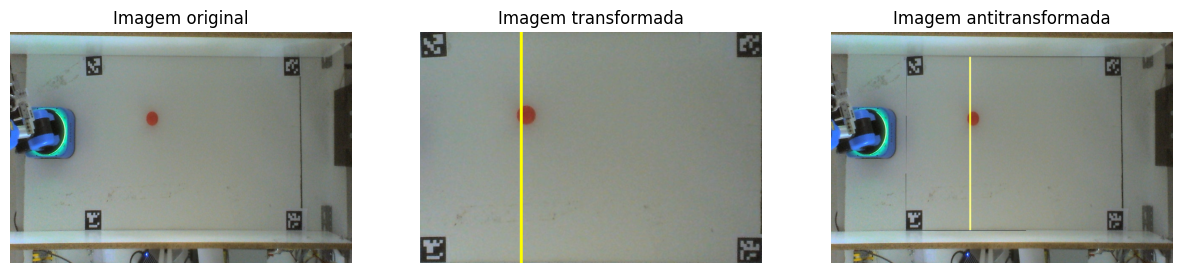

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for ax in axes:
    ax.axis("off")

axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect="auto")
axes[0].set_title("Imagem original")

axes[1].imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB), aspect="auto")
axes[1].set_title("Imagem transformada")

axes[2].imshow(cv2.cvtColor(img_antitransformed, cv2.COLOR_BGR2RGB), aspect="auto")
axes[2].set_title("Imagem antitransformada")